# Table of Contents
1. [Introduction](#introduction)
2. [Data Import and Exploration](#DataImport)<br>
    2.1 [Custom Colors](#CustomColors)<br>
    2.2 [Exploring The Data](#ExploringtheData)<br>
    2.3 [Fixing The Null](#FixingtheNull)<br>
3. [Temporal Analysis Methods and Visuals](#TemporalAnalysisAndVisualization)<br>
    3.1 [Midpoint Analysis](#MidpointAnalysis)<br>
    3.2 [Charting Midpoints](#ChartingAoristicMethod)<br>
    3.3 [Aoristic Method](#AoristicMethod)<br>
    3.4 [Charting Aoristic](#ChartingAoristic)<br>
4. [Spatial Clusters of Vehicle Burglaries](#VehicleBurglaryClusters)<br>
    4.1 [Elbow Method](#ElbowMethod)<br>
    4.2 [Creating Clusters and Charting](#CreatingAndChartingClusters)<br>
    4.3 [Time and Place Together](#TimeAndPlace)<br>
5. [Conclusion](#Conclusion)

# Introduction <a name="introduction"></a>
The public and law enforcement expect police resources to be proactively deployed to prevent crime, but risk is not evenly spread across time or space. Knowing where to deploy and when to deploy are equally important. Unfortunately, many crimes go unobserved and therefore lack important temporal data. This obviously makes knowing when to deploy more difficult. Once the when question is is answered, the next question is where should police deploy. Spatial deployments should be crime type specific. Spatial crime patterns relate to human behavior at specific locations. For instance, when would vehicle burglaries would more likely occur at a restaurant during lunch and dinner rather than at 4:00am because there are more opportunities for vehicle burglaires when there are a greater number of unattended cars in the parking lot. In a counter example, would a vacant field have more domestic disturbances than an apartment complex? Again, the answer relates to people and their beahvior at certain places and at certain times. 

The intent of this work is to demonstrate several temporal analysis techniques for crimes and to show how those matter when discussing spatial patterns. The bulk of this work is dereived from well-founded Crime Analysis literature and researchers. As the discussion dives deeper into the analysis I will cite the sources for your further reading and to properly give acknowlegement to the hard work of others.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import warnings  
warnings.filterwarnings('ignore')

['crime.xml', 'crime_1', 'crime.csv', 'offense_codes.csv', 'crime']


# Data Import and Exploration <a name="DataImport"></a>

In [2]:
data = pd.read_csv("../input/crime.csv", 
                   nrows=7000
                  ,parse_dates=['LAST_OCCURRENCE_DATE', 'FIRST_OCCURRENCE_DATE'])
df=pd.DataFrame(data)

## Custom Colors<a name="CustomColors"></a>
The obvious choice for a coloring scheme is shades of red and blue.

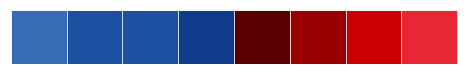

In [3]:
police_colors = ['#356CB5',  # Steel Blue
                 '#1B51A1',  # Cyan Cobalt Blue
                 '#1B51A1',
                 '#0F3C8B',  # Dark Cerulean
                 '#590000',
                 '#980001',  # Crimson Red
                 '#CC0000',  # Boston University Red 
                 '#E82734',  # Alizarin Crimson
                 ]
my_cmap = ListedColormap(sns.color_palette(police_colors).as_hex())

sns.set_palette(palette=police_colors)
sns.set_style("darkgrid")
sns.palplot(police_colors)

## Exploring the Data <a name="ExploringtheData"></a>

Crime time spans have been developed to create a temporal window encapsulating when the **crime could** have occurred. Data for time spans is generally collected by the officer upon taking the inital report. For crimes such as vehicle burglaries, officers solicit the last known time the property was intact, and then the time the break-in was discovery. Victims could report their car was secured on Date1 at 9:00pm and found burglarized on Date2 at 9:00am. In this example, at a minimum, there could be 12 hours time span in which the crime would have occurred.

In many instances however, crime time spans are not important. Events like vehicle accidents do not have time spans because because most drivers are able to give an accurate description for when the accident occurred. Police officers investigating accidents will generally complete a report and ensure that Date1/Time1 matches Date2/Time2.

For the remainder of the report I'll be comparing vehicle burglaries against accidents to demonstrate the differences between times and places for those two offense types. Before that begins, please take a moment to develop your own hypothesiss for what times and places vehicle burglaries and accidents will most frequent.

Most modern police databases will have strict quality control measures to ensure missing data is corrected. Police data usually most conform to strict Uniform Crime Reporting or National Incident Based Systems standards. Plotting null data shows most of the missing entries occurred in the Last_Occurrence_Date. In the coming code blocks I'll discuss why missing data can easily be replaced.

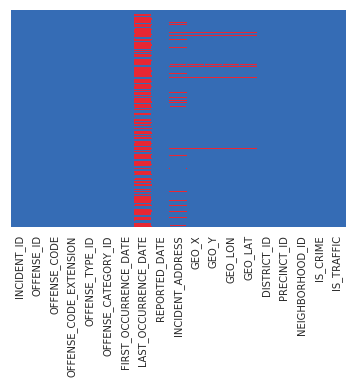

In [4]:
#plotting nulls
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap=my_cmap)

Grouping the data by Offense Category will segment by offense type. We'll compare the categories against one another and assess the nature of the missing LOD data. Below I will create 3 charts for comparison.

1. The first chart on the left plots how many offense reports were written per offense category. 
1. The middle chart plots a count of LODs per offense category. 
1. The chart on the right plots the difference between the the first and middle charts. 

The larger the number in the Difference chart, the larger the number of missing LODs. Traffic accidents are the highest category in the Difference chart, which makes sense because people generally know when the accident occurred. The second highest is All Other Reported, which is a catch-all category for crimes that are not easily classified. The results are typical for a crime dataset.

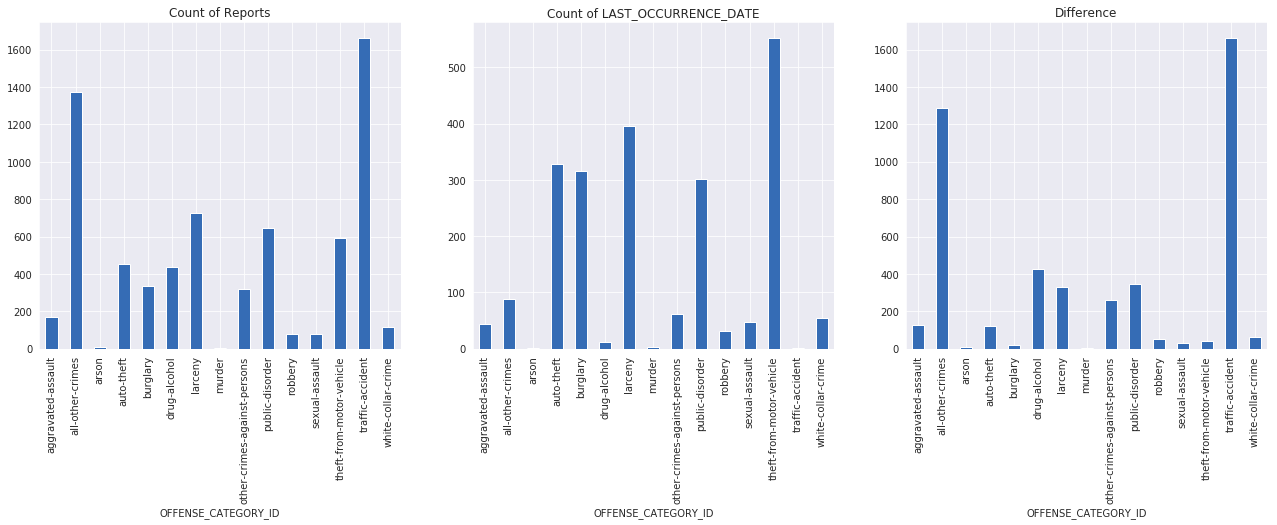

In [5]:
#Grouping offense types
CountofReports=df.groupby(df['OFFENSE_CATEGORY_ID']).size()
CountofLOD=df.groupby(df['OFFENSE_CATEGORY_ID'])['LAST_OCCURRENCE_DATE'].count()

#Finding a difference
Difference=CountofReports-CountofLOD

#plotting
fig,(ax1,ax2,ax3)= plt.subplots(figsize=(22,6),nrows=1,ncols=3)
CountofReports.plot(kind='bar',ax=ax1,cmap=my_cmap, title="Count of Reports")
CountofLOD.plot(kind ='bar',ax=ax2,cmap=my_cmap,title="Count of LAST_OCCURRENCE_DATE")
Difference.plot(kind='bar',ax=ax3,cmap=my_cmap,title='Difference')

## Fixing the Null <a name="FixingtheNull"></a>

After reviewing the data it seems safe to assume that many of the missing LOD values could be replaced with the FOD values where LOD is null. Replace null LOD with FOD will be important in the coming steps

The remaing null values of consequence are located in GeoX, and GeoY. Incident location is missing too, but that becomes less relevant when X's,Y's are present because geocoding the addresses is not necessary.

In [6]:
#Rename DateTime fields for better understanding of what's going on.
df.rename(columns={'FIRST_OCCURRENCE_DATE': 'BeginDate', 'LAST_OCCURRENCE_DATE': 'EndDate'}, inplace=True)

#replacing null LOD dates with FOD when LOD is null
df.EndDate.fillna(df.BeginDate,inplace=True)

#removing Lat,Long combos with missing data
df.dropna(subset=['GEO_X'],inplace=True)

# Temporal Analysis and Visualizations <a name="TemporalAnalysisAndVisualization"></a>

## Midpoint Analysis <a name="MidpointAnalysis"></a>

A common method to assess time spans is to create a Midpoint between the FOD and the LOD. A midpoint works well for smaller times spans but begins to degrade in reliability as the span increases in length. The midpoint is found in the following formula FOD+(LOD-FOD)/2.

As a general rules, crimes with time spans greater than 24 hours in length are removed from analysis. We can assess times spans >24 hours by comparing the hours from the FOD and LOD. Besides spans >24 hours, other special consideration must be made when assessing the hours within the span, hereafter called Hours in Range. Let's say a crime occurrs at 1:05pm. Did the crime occur in the 1 o'clock hour? Or in other words, should full weight of the crime be given to the 1 o'clock hour. Not likely given the crime could only have had minutes to occur. We probably shouldn't count 1 o'clock as being apart of the time span. But what if the crime occurs at 1:10pm? Did the crime occur in the 1 o'clock hour? At this point, we might say it could have and therefore full weight should be given to the hour. We'll also create a Hour1 and a Hour2 field that makes these assessments as well as appropriately counting hours that cross midnight.

The following formulas were created from a spreadsheet distributed by the International Association of Crime Analysts and was made by its former President Christopher Bruce. I am not able to find a linked source to the material for reference. I'd like to emphatically state that this work is not my own except that I translated an excel document and its formulas to python and pandas. I'd like to direct you to the IACA's webpage for more details or contact information. https://iaca.net/

The use of the Midpoint date, or sometimes I refer to it as Split Date, is necessary for some charting.

In [7]:
#finding hour1
df['Hour1']= df.BeginDate.dt.hour

#finding hour2 given comparative circumstances
df['Hour2']=np.where(
    (df['BeginDate'].dt.hour == df['EndDate'].dt.hour),
        df['EndDate'].dt.hour,
            np.where((df['EndDate'].dt.hour == 0) & (df['EndDate'].dt.minute<10),
                     23,
                         np.where((df['EndDate'].dt.minute<10),
                                  (df['EndDate'].dt.hour - 1),
                                      df['EndDate'].dt.hour)))

#creating an hours in range based on the two fields seen above
df['HoursInRange']= np.where((df['Hour1']>df['Hour2']), 25-(df['Hour1']-df['Hour2']),(df['Hour2']-df['Hour1']+1))

#filtering out all crimes with an Hours in Range >24 and renaing the dataframe
crimes=df[df['HoursInRange']<=24]

#creating the midpoint
crimes['SplitDate'] = crimes['BeginDate'] + (crimes["EndDate"] - crimes['BeginDate'])/2
crimes['SplitDate'] = crimes['SplitDate'].apply(lambda x: x.strftime('%m/%d/%Y %H:00:00'))
crimes['SplitDate'] = pd.to_datetime(crimes.SplitDate)

## Charting Midpoints <a name="ChartingMidpoints"></a>

Midpoints give us an one datetime field for us to use in heatmapping. Heatmaps open up the various attributes of time by letting us separate days, day number of year, month, and many others. The first heatmap will plot vehicle burglaries by day and hour using the Midpoint, whereas the second chart will only plot vehilce accidents by day and hour using the Midpoint. 

Vehicle burglaries occur during the night in residential areas because that's when unattending vehilcles can be ransacked for valuable goods, but the busiest time of day for accidents is when the greater oppportunity for accidents appears, rush hour.

In [8]:
def Heatmap_daysXhours(data_frame, groupby_field, count_field, off):
    heat_group=data_frame.groupby(data_frame[groupby_field], as_index=True, sort=True)[count_field].count()
    heat_data=pd.DataFrame(heat_group)
    heat_data['Hours']= heat_data.index.hour
    heat_data['Days']= heat_data.index.day_name()
    heat_data_pivot=pd.pivot_table(heat_data,values=count_field, index='Days',columns='Hours',fill_value=0)
    
    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    fig,(ax,cbar_ax)= plt.subplots(2,figsize=(15,7),gridspec_kw=grid_kws)
    ax.set_title(off+' by Time of Day and Day of Week',fontsize=18)
    cbar_ax.set_title('Count of Police Reports',fontsize=12)
    ax = sns.heatmap(heat_data_pivot, square=True,
                     cmap=my_cmap, annot=True,
                     linewidths=.01, ax=ax,
                     cbar_ax=cbar_ax, 
                     cbar_kws={"orientation": "horizontal"})
    ax.set_ylabel("Days of the Week", fontsize=15)
    ax.set_xlabel("24 Hours of the Day", fontsize=15)

Big differences appear between these two types of occurrences. Vehicle burglaries happend during the late and early hours of the day, where as vheilce accidents happen during rush hours.

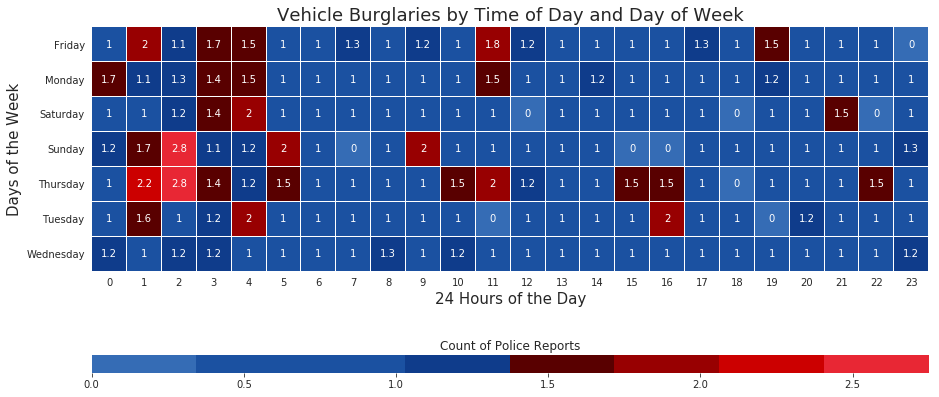

In [9]:
vehicleburglary=crimes[crimes['OFFENSE_CATEGORY_ID']=='theft-from-motor-vehicle']
Heatmap_daysXhours(vehicleburglary,'SplitDate','INCIDENT_ID','Vehicle Burglaries')

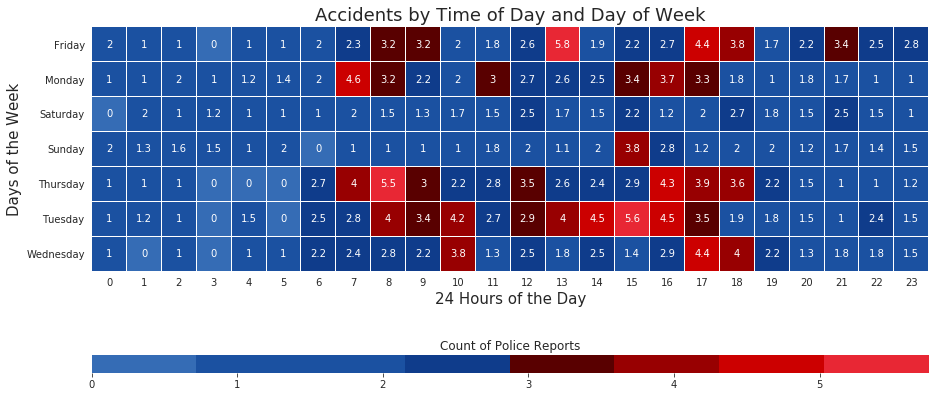

In [10]:
accidents=crimes[crimes['OFFENSE_CATEGORY_ID']=='traffic-accident']
Heatmap_daysXhours(accidents,'SplitDate','INCIDENT_ID','Accidents')

## Aoristic Method <a name="AoristicMethod"></a>

In the previous sections we discussed midpoint as a viable analysis, but midpoint has weaknesses with lengthy crime time spans. And yet we are still compelled to do something about crime problems with unknown conditions.

Another time span analysis is called Aoristic. Aoristic analysis weights each hour in the time span by dividing 1 crime by the Hours in Span (1/Hours in Span). If the crime occurred exactly at 2:30pm, then the hours in span is 1, therefore 1 crime divided by 1 hour in the span is 1. This means the 2 o'clock hour carries the full weight of the crimes. Crimes spanning two hours have a weight of .5 and so on. The Aoristic process then assigns the weighted value to each hour in the span. When the weights are aggregated we get a picture of which hours in the time span are weighted more heavier than others, meaning the crime is more likely to occur in the heavier hours.

The visualization helps to demonstrate how weights are accumlated on successive cases to produce higher weights for riskier times. The image was taken from Dr. Jerry Ratcliffe's work and cited below. Think of row (a) as being an offense with a four hour time span. Each span wieght is distibuted across hours "Search 1' through 'Search 4'. The image's foot contains a summation of all the weights and is used to assess which hours are the most risky. In the image, 'Search 3' aggregated the most weights making the hour the most risky.

![image](https://www.researchgate.net/profile/Greg_Jenion/publication/237546655/figure/fig1/AS:669026162339842@1536519675153/Aoristic-Analysis.png)

The following formulas were created from a spreadsheet distributed by the International Association of Crime Analysts and was made by its former President Christopher Bruce. I am not able to find a linked source to the material for reference. I'd like to emphatically state that this work is not my own except that I translated an excel document and its formulas to python and pandas. I'd like to direct you to the IACA's webpage for more details or contact information. https://iaca.net/

Ratcliffe, J.H. (March,2002), Aoristic Signatures and the Spatio-Temporal Analysis of High Volume Crime Pattrens. Journal of 
    Quantitative Criminology Volume 18, No. 1.Retrieved from 
    https://docs.wixstatic.com/ugd/f5df24_35424f29c99b4f76b22c136dc09377a8.pdf on 06/02/2019.

In [11]:
#creating a weight function and applying the function to a new column
def Weight(Span): 
    try: 
        return round(1/Span,3) 
    except ZeroDivisionError: return 1

#applying the weights to a new column    
crimes['Weight']=crimes['HoursInRange'].apply(Weight)


#Creating 24 columns, which are hours of the day, and appling the algo's results for each case to each applicable hour

#Previously I was doing this for 24 hours in a day
#df['01:00'] = np.where((df['Hour2'] >= df['Hour1']),
                    #np.where((1>=df['Hour1']) & (1<=df['Hour2']),df['Weight'],0),
                        #np.where( (1<=df['Hour2']) | (1>=df['Hour1']),df['Weight'],0))

#now I'm doing this instead of what's above here.
x=np.arange(0,24,1)
for i in x:
    crimes[i]=np.where((crimes['Hour2'] >= crimes['Hour1']),
                       np.where((i>=crimes['Hour1']) & (i<=crimes['Hour2']),crimes['Weight'],0),
                           np.where( (i<=crimes['Hour2']) | (i>=crimes['Hour1']),crimes['Weight'],0))

crimes.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,BeginDate,EndDate,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,Hour1,Hour2,HoursInRange,SplitDate,Weight,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,2016-06-15 23:31:00,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0,23,23,1,2016-06-15 23:00:00,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,1.000
1,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,2017-10-11 16:55:00,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0,12,16,5,2017-10-11 14:00:00,0.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.000,0.000,0.000,0.000
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,2016-04-25 08:00:00,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0,20,7,12,2016-03-30 14:00:00,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083,0.083,0.083,0.083
3,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,2018-01-30 19:20:00,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0,19,19,1,2018-01-30 19:00:00,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.000,0.000,0.000
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,2017-06-22 20:53:00,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0,20,20,1,2017-06-22 20:00:00,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,0.000,0.000


## Charting Aoristic <a name="ChartingAoristic"></a>

In [12]:
def Aoristic_Chart(data,chart_offense):
    ax = data.iloc[20:44].plot(
        xticks=np.arange(0,24,1),
        grid=True,
        figsize=(15,7),
        fontsize=16)
    ax.set_xlim([0,23])
    ax.set_ylabel("Aoristic Values", fontsize=15)
    ax.set_xlabel("24 Hours of the Day",fontsize=15)
    ax.set_title('Weighted Hours for '+chart_offense,fontsize=18)

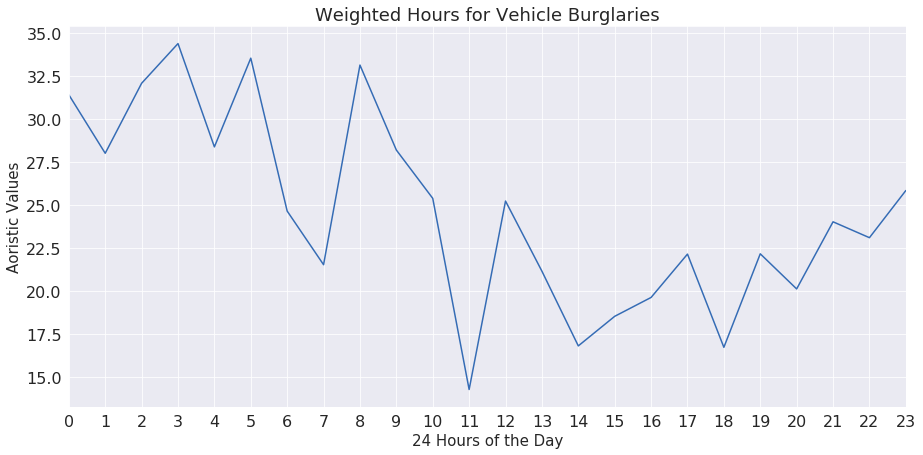

In [13]:
#Grouping vehicle burglaries together
VehicleBurglary=crimes[crimes['OFFENSE_CATEGORY_ID']=='theft-from-motor-vehicle']
VehicleBurglary_line=VehicleBurglary.sum()

#applying the chart
Aoristic_Chart(VehicleBurglary_line, 'Vehicle Burglaries')

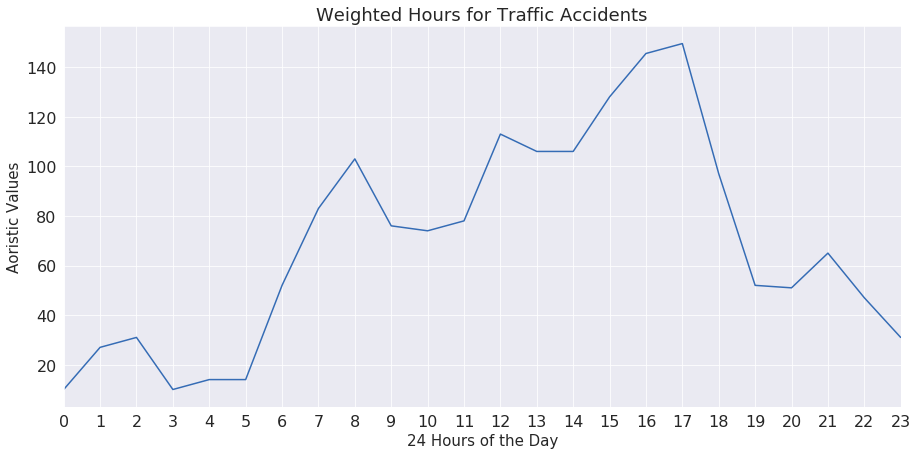

In [14]:
#Group accidents together
accidents=crimes[crimes['OFFENSE_CATEGORY_ID']=='traffic-accident']
accidents_line=accidents.sum()

#applying the chart
Aoristic_Chart(accidents_line,"Traffic Accidents")

# Spatial Clusters of Vehicle Burglaries <a name="#VehicleBurglaryClusters"></a>

Tobler's first law of geography states "everything is related to everything else, but near things are more related than distant things." Nearer crimes are more related that distant crimes, therefore clustering offenses by location becomes helpful. The more centroids we apply to the data pionts, the more improved the error rate becomes. If we apply as many centroids as there are data points, then the error rate will completely minimize, but we then create as many clusters as there are data points which is not the purpose of grouping like ojbects.

I'll be using the elbow method to assess the appropriate number of centroids for this dataset. The elbow method plots the error rate as a function of the number of clusters. The elbow chart visuallizes the function and is useful for picking a point on the line where the addition of a new cluster has little effect on the error rate. In the future, I'd like to find a method for applying the second derivative to the line as a secondary visual aide.

In [15]:
#Getting my Vehicle Burglary data
VehicleBurglary_Clusters=VehicleBurglary[['GEO_LAT','GEO_LON']]

## Elbow Method <a name="ElbowMethod"></a>

In [16]:
def Elbow_Method(k_clusters,data):
    errors = []
    K = range(1,k_clusters)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(data)
        kmeanModel.fit(data)
        errors.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
        
    plt.figure(figsize=(10,6))
    plt.plot(K,errors)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

Optimal number of centroids appears to be about 8 to my eyes. Nine to 11 seem viable too.

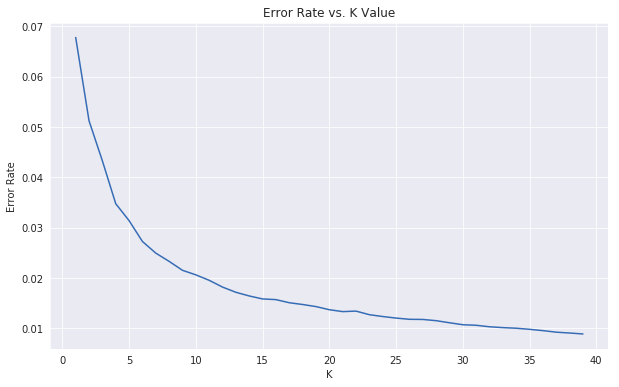

In [17]:
Elbow_Method(40,VehicleBurglary_Clusters)

## Creating and Charting Clusters <a name="CreatingAndChartingClusters"></a>

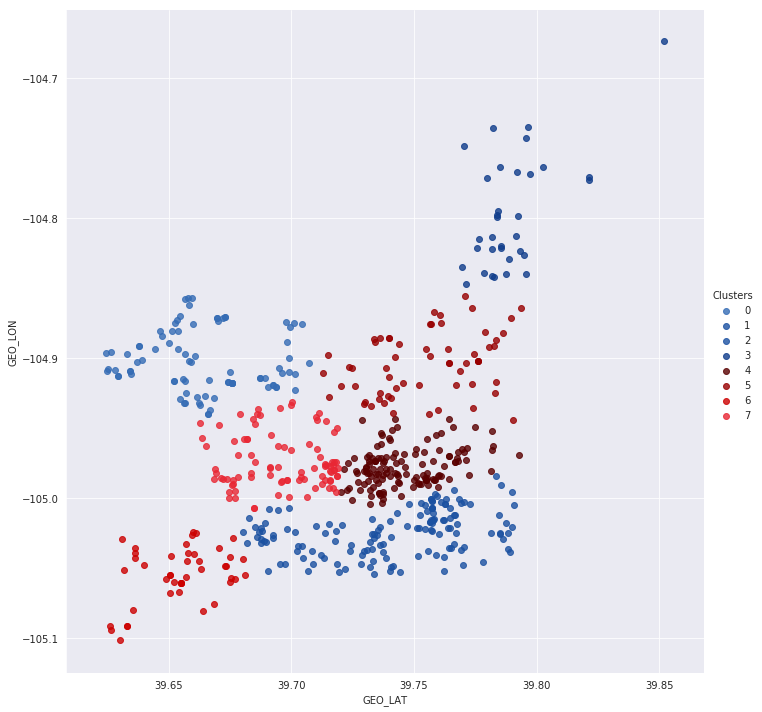

In [18]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(VehicleBurglary_Clusters)
kmeans.cluster_centers_
VehicleBurglary['Clusters']=kmeans.labels_

sns.lmplot(x='GEO_LAT',y='GEO_LON',data=VehicleBurglary,
           hue='Clusters',
           fit_reg=False,
           size=10)

## Time and Place Together <a name="TimeAndPlace"></a>

So far this work has evaluted two temporal methods for evaluating crime and one method for spatial analysis. The original question police practioners require is a combination of both. Where and when do we deploy? In the following section I'll break down each cluster and evalute the spatial and temporal elements.

In [19]:
def Aoristic_And_Clusters(data,cluster_number):
    
    cluster=data[data['Clusters']==cluster_number]
    cluster_line=cluster.sum()
    
    
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(22,6))
    
    sns.regplot(x='GEO_LAT',y='GEO_LON',data=cluster,
           fit_reg=False,color='red',ax=ax1)
    
    ax2=cluster_line.iloc[21:45].plot(xticks=np.arange(0,24,1))

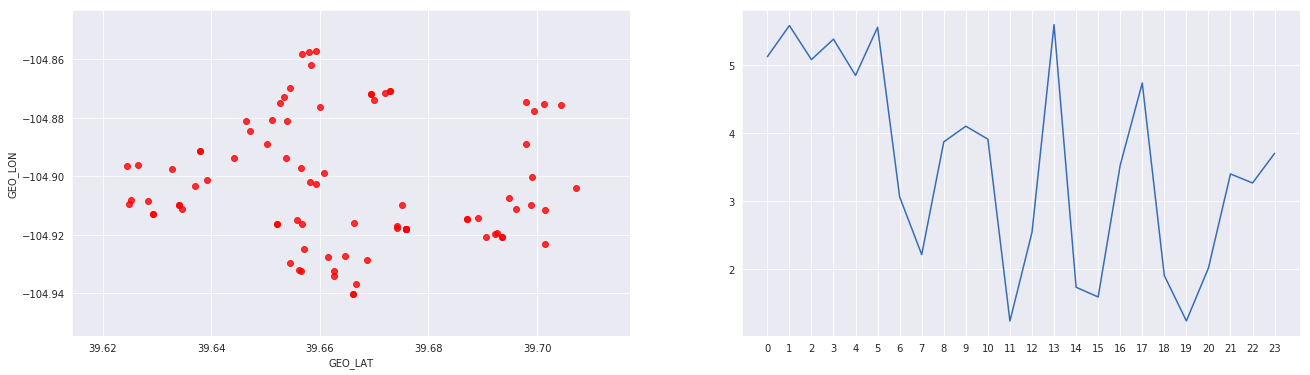

In [20]:
Aoristic_And_Clusters(VehicleBurglary,0)

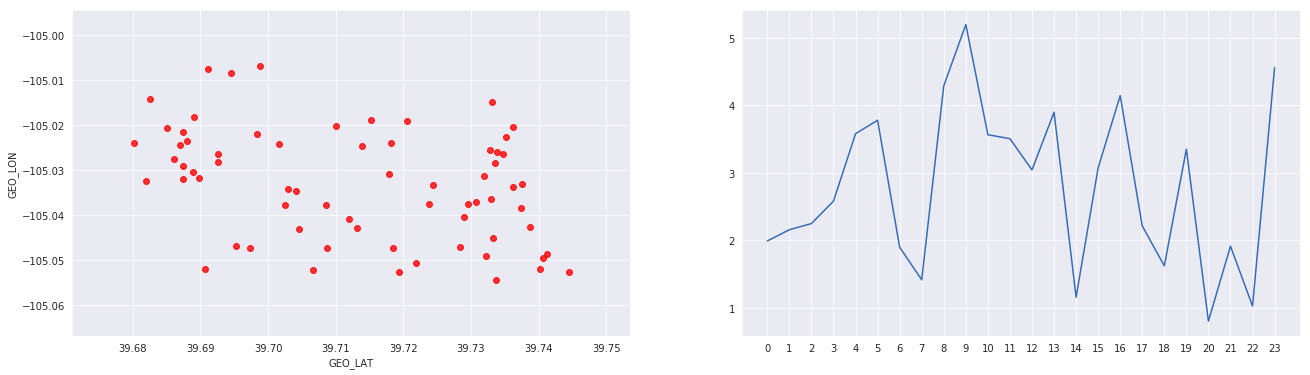

In [21]:
Aoristic_And_Clusters(VehicleBurglary,1)

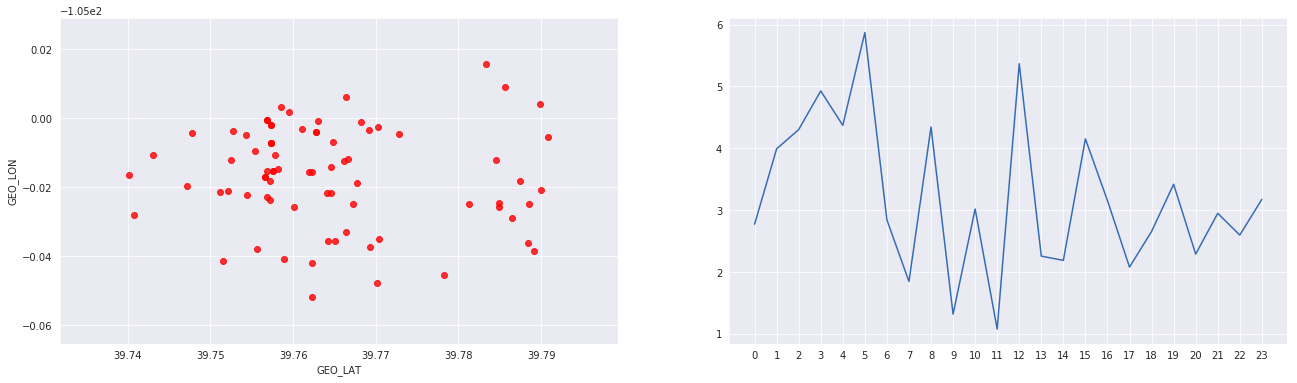

In [22]:
Aoristic_And_Clusters(VehicleBurglary,2)

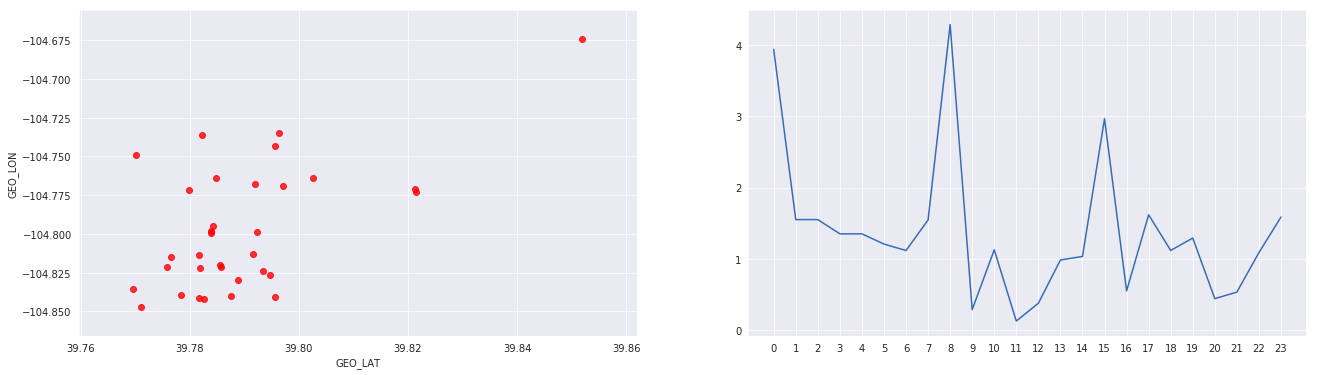

In [23]:
Aoristic_And_Clusters(VehicleBurglary,3)

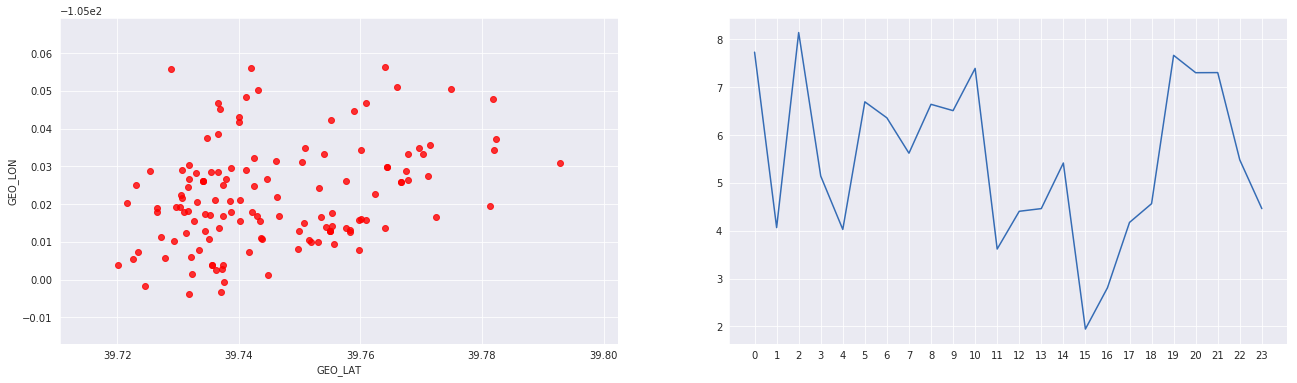

In [24]:
Aoristic_And_Clusters(VehicleBurglary,4)

## Conclusion <a name="Conclusion"></a>

Thank you for choosing to read over my work. I greatly appreciate your feed back. I am very thankful for this opportunity to learn, explore, and have fun.